<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/1_Bidirectional_LSTM_Multivariate_Horizon_Style_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [262]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [263]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
 #               infer_datetime_format=True)
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/Network-Flows.csv'
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)



#df = pd.read_csv(url,index_col='Processing_time',
#               # infer_datetime_format=True)
#                parse_dates=True)

In [264]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [265]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [266]:
#df.drop_duplicates(subset=['Processing_time'], keep=False,inplace=True)

In [267]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [268]:
df = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [269]:
validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(50)
df.drop(df.tail(50).index,inplace=True)

In [270]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [271]:
validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(100)
df.drop(df.tail(100).index,inplace=True)

In [272]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [273]:
"""
#hist_window = 48
#horizon = 10
hist_window =35
#horizon = 30
horizon = 10
"""
#hist_window =200
#hist_window =300
#hist_window =50
hist_window =150
horizon = 100


TRAIN_SPLIT = 5500
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [274]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.00318907 1.         1.         ... 0.92620063 0.83064738 0.53022238]
 [0.00501139 1.         1.         ... 0.5560866  0.51308245 0.95353474]
 [0.00592255 1.         1.         ... 0.54369195 0.65795782 0.94257725]
 ...
 [0.00318907 1.         1.         ... 0.42616427 0.5316785  0.96207189]
 [0.0022779  1.         1.         ... 0.59375971 0.68094559 0.94541046]
 [0.0022779  1.         1.         ... 0.45972567 0.43888999 0.96841732]]

 Target horizon
[[0.96310463]
 [0.94614406]
 [0.95992111]
 [0.94780918]
 [0.55984877]
 [0.95792729]
 [0.96227093]
 [0.96019067]
 [0.93869766]
 [0.94313115]
 [0.95847209]
 [0.95846072]
 [0.9766178 ]
 [0.96804994]
 [0.9483392 ]
 [0.56652063]
 [0.95855285]
 [0.96219473]
 [0.95229727]
 [0.95538639]
 [0.9466593 ]
 [0.9633958 ]
 [0.95261688]
 [0.96102778]
 [0.95452767]
 [0.94858374]
 [0.97563284]
 [0.54414274]
 [0.95349607]
 [0.93493976]
 [0.94970178]
 [0.95715274]
 [0.9527818 ]
 [0.94915129]
 [0.95099839]
 [0.96450588]
 [0.9

In [275]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
#BATCH_SIZE = 64
#BUFFER_SIZE = 37
#BATCH_SIZE = 150
#BATCH_SIZE = 64
#BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [276]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')


In [277]:
model_path = r'Bidirectional_LSTM_Multivariate.h5'

In [278]:
#EVALUATION_INTERVAL = 100
#EPOCHS = 150
#EVALUATION_INTERVAL = 70
EVALUATION_INTERVAL = 100
#EPOCHS = 150
EPOCHS = 150
#history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 14s 86ms/step - loss: 0.4305 - val_loss: 0.0438
Epoch 2/150
100/100 [==============================] - 7s 75ms/step - loss: 0.0714 - val_loss: 0.0349
Epoch 3/150
100/100 [==============================] - 8s 75ms/step - loss: 0.0513 - val_loss: 0.0178
Epoch 4/150
100/100 [==============================] - 7s 74ms/step - loss: 0.0427 - val_loss: 0.0134
Epoch 5/150
100/100 [==============================] - 7s 74ms/step - loss: 0.0358 - val_loss: 0.0349
Epoch 6/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0308 - val_loss: 0.0179
Epoch 7/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0288 - val_loss: 0.0240
Epoch 8/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0305 - val_loss: 0.0134
Epoch 9/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0267 - val_loss: 0.0118
Epoch 10/150
100/100 [==============================] - 7s 72ms/step - loss: 0.02

In [279]:
Trained_model = tf.keras.models.load_model(model_path)

In [280]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 150, 300)          195600    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 100)               140400    
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2020      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               2100      
Total params: 340,120
Trainable params: 340,120
Non-trainable params: 0
_________________________________________________________________


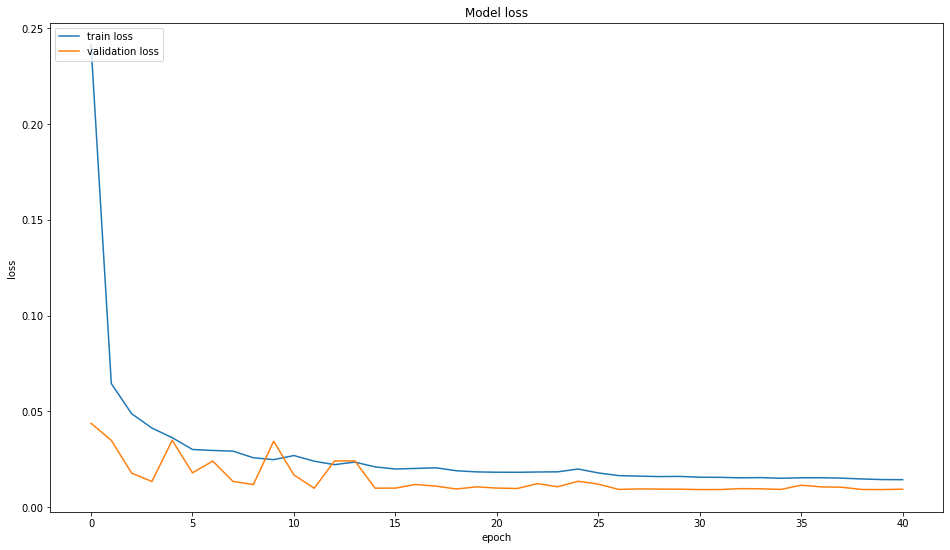

In [281]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [282]:
data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100))

In [283]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [284]:
Predicted_results = Trained_model.predict(val_rescaled)

In [285]:
Predicted_results

array([[0.7141458 , 0.7143285 , 0.70791185, 0.7126968 , 0.6973417 ,
        0.7029123 , 0.69904715, 0.69166887, 0.7117429 , 0.70955086,
        0.71706796, 0.7180033 , 0.70175385, 0.71505564, 0.7145311 ,
        0.68936586, 0.6969328 , 0.69396913, 0.7089774 , 0.7123755 ,
        0.71818745, 0.70174974, 0.69727045, 0.70913213, 0.6990031 ,
        0.71735656, 0.70639   , 0.70613956, 0.69511694, 0.7167064 ,
        0.70443904, 0.7141404 , 0.7144302 , 0.7065394 , 0.71878266,
        0.71589744, 0.7023815 , 0.7134365 , 0.7112012 , 0.7184484 ,
        0.70033824, 0.71857524, 0.7141402 , 0.71649575, 0.71656656,
        0.71060765, 0.70202756, 0.7149619 , 0.71156704, 0.7048125 ,
        0.71072316, 0.693431  , 0.7171912 , 0.71244067, 0.7057828 ,
        0.70078677, 0.7155088 , 0.7007351 , 0.7169248 , 0.7101568 ,
        0.69899344, 0.7179743 , 0.7080963 , 0.71067005, 0.71690583,
        0.7095075 , 0.70914054, 0.7063311 , 0.69258404, 0.7180689 ,
        0.6887595 , 0.7073256 , 0.71238387, 0.71

In [286]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [287]:
Predicted_results_Inv_trans

array([[671960.44, 672121.06, 666479.44, 670686.44, 657186.  , 662083.75,
        658685.44, 652198.4 , 669847.75, 667920.5 , 674529.6 , 675352.  ,
        661065.25, 672760.4 , 672299.2 , 650173.5 , 656826.5 , 654220.75,
        667416.3 , 670404.  , 675513.94, 661061.6 , 657123.4 , 667552.3 ,
        658646.75, 674783.4 , 665141.44, 664921.2 , 655229.94, 674211.75,
        663426.06, 671955.7 , 672210.5 , 665272.75, 676037.25, 673500.5 ,
        661617.06, 671336.8 , 669371.5 , 675743.3 , 659820.6 , 675854.9 ,
        671955.5 , 674026.56, 674088.8 , 668849.6 , 661305.9 , 672677.94,
        669693.1 , 663754.44, 668951.2 , 653747.7 , 674638.  , 670461.25,
        664607.5 , 660214.94, 673158.8 , 660169.5 , 674403.75, 668453.25,
        658638.25, 675326.5 , 666641.6 , 668904.5 , 674387.06, 667882.4 ,
        667559.75, 665089.6 , 653003.  , 675409.7 , 649640.4 , 665964.  ,
        670411.3 , 671950.4 , 671713.8 , 672421.8 , 664654.5 , 662327.1 ,
        670791.9 , 670725.44, 654671.4

In [288]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [289]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 12115839085.798203
MAE is : 103588.935
RMSE is : 110071.97229902897
MAPE is : 15.378322310064213
R2 is : -0.5474838236614781



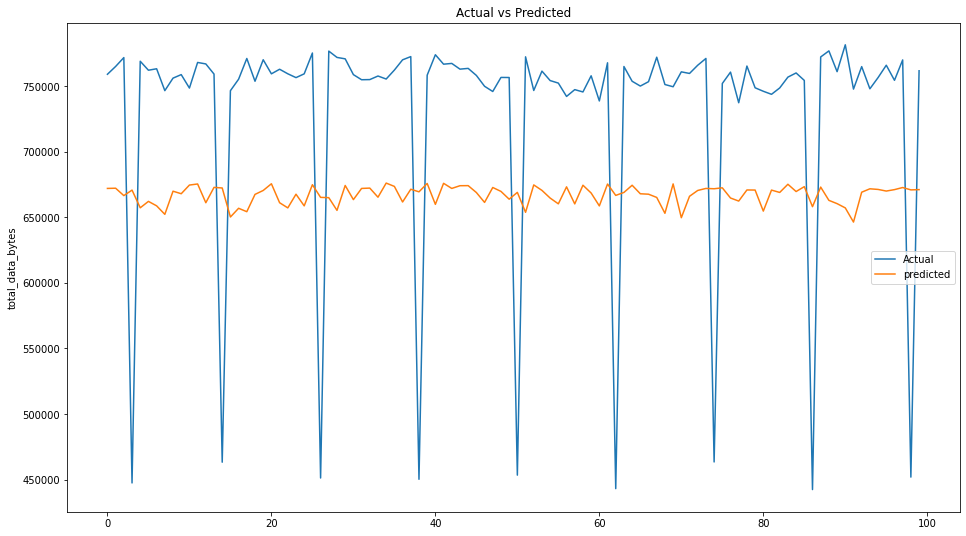

In [290]:
plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("total_data_bytes")
plt.legend(('Actual','predicted'))
plt.show()